In [6]:
import sys, os
import geopandas as gpd
import pyproj

# Manually force the correct proj data path
os.environ["PROJ_LIB"] = "/home/kwameatt/anaconda3/envs/cs231n/share/proj"
pyproj.datadir.set_data_dir("/home/kwameatt/anaconda3/envs/cs231n/share/proj")
gdf = gpd.GeoDataFrame(
    {"LON": [10], "LAT": [50]},
    geometry=gpd.points_from_xy([10], [50]),
    crs="EPSG:4326"
)

print("Success! CRS is:", gdf.crs)

#for packages
project_root = os.path.abspath(".")
src_path = os.path.join(project_root, "src")

if src_path not in sys.path:
    sys.path.insert(0, src_path)



Success! CRS is: EPSG:4326


In [2]:
#hopefully this will fix the CRS import problem PERMANENTLY
%run src/pyproj_fix.py

In [7]:
from __future__ import division
import numpy as np
import pickle
import torch, random, copy
import torch.optim as optim
from torch import nn
from isgnn.sh_utils import *
from isgnn.sh_post_utils import *
from isgnn.basic_structure import IGNNK_ModOptionB
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import pandas as pd
import re
from shapely.geometry import Point, LineString
from geopy.distance import geodesic
import geopandas as gpd
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt


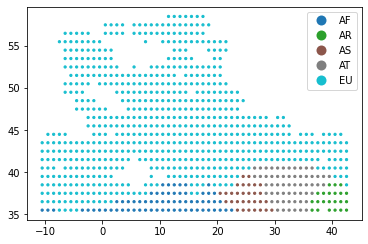

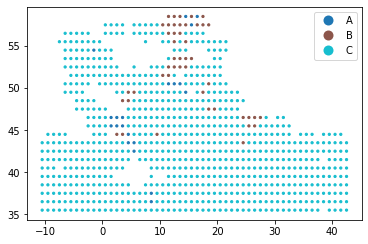

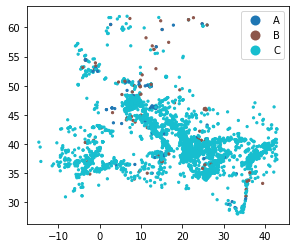

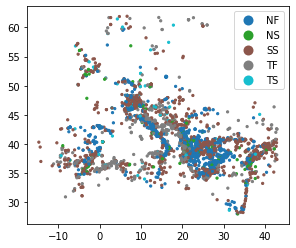

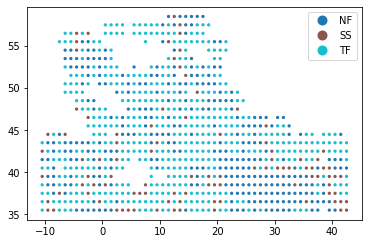

In [8]:
set_seed(42)

# Load training data = Anchor + grid nodes
grid_gdf_path = "/mnt/e/GNN_paper/iS-GNN/data/grids_train/all_grid_data_1p0r.csv"
anchor_data_path = "/mnt/e/GNN_paper/iS-GNN/data/grids_train/WSM2025_EU.csv"

#generate, clean, and process data, then construct the graph adjacency and feature matrix 
kNN=12
th_bound = 20 #in degrees
p_boundary_bound_km = 90 #in kilometers
q_mode = "linear" # or inverse
sigma_km = 150.0 # manual boundary sharpness for adjacency
quality_frac= 0.10
q_r_km = 300
w_0 = 0.7
r_0 = 75

sh_dat = generate_shmax_train_data(anchor_data_path,
                              grid_gdf_path,
                              kNN = kNN,
                              qual_R_km = sigma_km,
                              Q_cut_frac = quality_frac,
                              Q_mode=q_mode,
                              theta_bound_deg = th_bound,
                              boundary_bound_km = p_boundary_bound_km,
                              kernel_w_0 = w_0, #to aid sigma_km auto selection
                              kernel_percentile_r_0 = r_0 #to aid sigma_km auto selection
                              )

A, X_target, grid_gdf, anchor_gdf, node_info = load_shmax_train_data()

df_cols = ['ID', 'LON', 'LAT', 'DEPTH', 'DIST', 'PLATE', 'QUALITY', 'REGIME', 'AZI', 'geometry']
grid_gdf = grid_gdf[df_cols] 
anchor_gdf = anchor_gdf[df_cols]
node_info = node_info[df_cols]
# test_anchor_data = test_anchor_data[df_cols]

grid_gdf.plot(column='PLATE', markersize=5, legend=True)
grid_gdf.plot(column='QUALITY', markersize=5, legend=True)
anchor_gdf.plot(column='QUALITY', markersize=5, legend=True)
anchor_gdf.plot(column='REGIME', markersize=5, legend=True)
grid_gdf.plot(column='REGIME', markersize=5, legend=True)

In [9]:
sigma_km = auto_sigma_km_from_knn(
        node_info["LON"].values, 
        node_info["LAT"].values, 
        kNN=kNN, 
        percentile=r_0, 
        w0=w_0)

sigma_km

91.35778806977889

In [10]:
#save training data files
results_dir = "/mnt/e/GNN_paper/iS-GNN/data/results_train"
fname0 = f"training_data_1p0r_grid.csv"
fname1 = f"training_data_1p0r_anchor.csv"
csv_path0 = os.path.join(results_dir, fname0)
csv_path1 = os.path.join(results_dir, fname1)
node_info[node_info["ID"].str.startswith("grid_")].to_csv(csv_path0, index=False)
node_info[node_info["ID"].str.startswith("wsm")].to_csv(csv_path1, index=False)

In [11]:
max_dist  = node_info['DIST'].max()
dist_feat  = node_info['DIST'].fillna(0) / max_dist

categorical_cols = ['PLATE', 'QUALITY','REGIME']
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(node_info[categorical_cols])

##
# Save encoder
with open("/mnt/e/GNN_paper/iS-GNN/data/num_array_files/ppb_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)
###

cat_features = encoder.transform(node_info[categorical_cols].fillna('Unknown'))

X_aux = np.column_stack([dist_feat, cat_features])
X_total = np.concatenate([X_target, X_aux], axis=-1)   # (N , h_total)

# print(f" Prepared input: {X_total.shape[0]} nodes x {X_total.shape[1]} features")
N, h_total = X_total.shape
h_target = X_target.shape[1] 
h_aux = h_total - h_target

#prepare mask
anchor_mask = (np.abs(X_total[:, 0]) + np.abs(X_total[:, 1])) > 1e-4
grid_mask = ~anchor_mask

#######
rng = np.random.default_rng(42)          # reproducible split
anchor_idx = np.where(anchor_mask)[0]
val_frac   = 0.15                       # 15 % hold-out
val_idx    = rng.choice(anchor_idx,
                        size=int(len(anchor_idx) * val_frac),
                        replace=False)
train_idx  = np.setdiff1d(anchor_idx, val_idx)

# training / validation node sets
know_set = set(train_idx)   # used for sub-graph sampling in training
val_set  = set(val_idx)     # used only for validation metric
#####
# anchor_idx = np.where(anchor_mask)[0]
grid_idx = np.where(grid_mask)[0]
unknow_set = set(grid_idx)
### Build pools
anchors = list(know_set)          # Va
grids   = list(unknow_set)        # Vg


In [12]:
# know_set = training anchors; val_set = held-out anchors; unknow_set = grids

train_anchor_idx = set(know_set)            # NO val anchors inside
proto_xy, proto_cs = build_anchor_prototypes(
    node_info=node_info,
    X_total=X_total,                         # shape (N, h_total) with first 2 = targets
    train_anchor_idx=train_anchor_idx,
    K=10,                                     
    w_space=0.5
)

P = prototype_prior(                         # (2, N)
    node_info=node_info,
    proto_xy=proto_xy, proto_cs=proto_cs,
    sigma_km=sigma_km,                           # spatial influence;
    topK=3                                   # blend at most the 2 nearest prototypes
)


In [9]:
len(know_set)

3797

In [13]:
# Original
# X_total = np.concatenate([X_target, X_aux], axis=-1)  # (N, 2 + p)

# New: append prior channels (do NOT put them into the target’s first 2 slots)
X_total = np.concatenate([X_total, P.T], axis=1)        # now (N, 2 + p + 2)

# Keep track of sizes
h_target = 2
h_total  = X_total.shape[1]          # this increased by 2
h_aux    = h_total - h_target

In [14]:
#Set Hyperparameters
n_o_n_m     = min(300, len(know_set)+len(unknow_set))
# n_m         = 60
ramp_epochs = 30
z           = 96
k           = 1 # 1 worked fine as well
Max_episode = 150
learning_rate = 5e-4
batch_size  = 64
drop_p = 0.5 #dropout probability

E_maxvalue = 1.0   # cos/sin already [-1,1]
A_anchor = A[np.ix_(list(know_set), list(know_set))]

#Instantiate Model
STmodel = IGNNK_ModOptionB(h_total, h_target, z, k, dropout=drop_p)
criterion = nn.MSELoss()
optimizer = optim.Adam(STmodel.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',        # lower val error is better
    factor=0.5,        # halve LR on plateau
    patience=5,        # epochs to wait with no improvement
    threshold=1e-3,    # min change to count as improvement
    cooldown=2,        # epochs to wait after LR drop before resuming tracking
    min_lr=1e-6,       # don't go below this
    verbose=True       # prints LR reductions
)

# doing the following for file names to be used later
data_dir = '/mnt/e/GNN_paper/iS-GNN/data/results_train'
w_0_str = f"{w_0:.0e}".replace("-", "m")
lr_str = f"{learning_rate:.0e}".replace("-", "m")
k_str = f"{k}".replace("-", "m")
k_nn = f"{kNN}".replace("-", "m")
k_p_r_0 = f"{int(r_0)}".replace("-", "m")
# tags = f"ep{Max_episode}_bs{batch_size}_lr{lr_str}_z{z}_nm{n_m}"
tags = f"ep_{Max_episode}_bs{batch_size}_lr_{lr_str}_k_diff_{k_str}_kNN_{k_nn}_kernel_r_0_{k_p_r_0}_w_0_{w_0_str}"
file_prefix = f"{tags}"

In [15]:
set_seed(42)

# Split input into:
X_target_full = X_total[:, :2]  
X_aux_full    = X_total[:, 2:]  

# Prepare test set for evaluation
X_T = X_target_full.T

# Initialise metric logs
RMSE_list = []
MAE_list = []
R2_list = []
ang_mae_grid_list = []
loss_list = []
ang_mae_val_list =[]

best_state = None
best_mae = 1e9
best_val = 1e9
patience = ramp_epochs 
patience_counter = 0

rng = np.random.default_rng(42)
pseudo_grid_idx = rng.choice(anchors, size=max(1, int(0.2 * len(anchors))), replace=False).tolist()

# Training Loop
for epoch in range(Max_episode):
    STmodel.train()
    n_m_epoch = current_mask_count(epoch,
                                   ramp_epochs=ramp_epochs,
                                   n_nodes=n_o_n_m,
                                   p0=0.20,  # start 20 %
                                   p1=0.50)  # end  50 %
    epoch_loss = 0.0
    for _ in range(batch_size):
        # know_mask = set(random.sample(know_set, n_o_n_m))
        nA_req = int(0.6 * n_o_n_m)
        nA = min(nA_req, len(anchors))
        nG = min(n_o_n_m - nA, len(grids))

        sub_A = random.sample(anchors, nA)
        sub_G = random.sample(grids,   nG)
        sub_idx = sub_A + sub_G  # anchors first, then grids
        nS = len(sub_idx)

        X_sub_target = X_target_full[sub_idx, :]  # (nS, 2)
        X_sub_aux    = X_aux_full[sub_idx, :]
        X_sub        = np.concatenate([X_sub_target, X_sub_aux], axis=1)

        # --- two masks ---
        m = min(n_m_epoch, nA)
        mask_anchor_locs = random.sample(range(nA), k=m) if m > 0 else []

        # input mask: zero targets for grids + masked anchors
        miss_mask_in = np.ones((nS, h_total), dtype=np.float32)
        if nG > 0:
            miss_mask_in[nA:, :h_target] = 0.0
        if m > 0:
            miss_mask_in[mask_anchor_locs, :h_target] = 0.0

        # loss mask: 1 only on masked anchors
        mask_loss = np.zeros((nS, h_target), dtype=np.float32)
        if m > 0:
            mask_loss[mask_anchor_locs, :] = 1.0

        # pack tensors
        Mf_inputs = torch.from_numpy((X_sub * miss_mask_in / E_maxvalue).T[np.newaxis].astype(np.float32))
        outputs_t = torch.from_numpy(X_sub[:, :h_target].T[np.newaxis].astype(np.float32))
        mask_t    = torch.from_numpy(mask_loss.T[np.newaxis].astype(np.float32))


        # Adjacency
        A_sub = A[np.ix_(sub_idx, sub_idx)]
        A_q = torch.from_numpy(calculate_random_walk_matrix(A_sub).T.astype(np.float32))
        A_h = torch.from_numpy(calculate_random_walk_matrix(A_sub.T).T.astype(np.float32))

        # Forward / Backward
        optimizer.zero_grad()
        X_pred = STmodel(Mf_inputs, A_q, A_h)
        loss = criterion(X_pred * mask_t, outputs_t * mask_t)
        epoch_loss  += loss.item()
        loss.backward()
        optimizer.step()

    # Evaluation (val anchors + pseudo-grid) 
    STmodel.eval()
    with torch.no_grad():
        X_full_T = X_total.T.astype('float32')          # (h_total, N)
        inp  = torch.from_numpy(X_full_T[np.newaxis])
        A_q  = torch.from_numpy(calculate_random_walk_matrix(A).T.astype('float32'))
        A_h  = torch.from_numpy(calculate_random_walk_matrix(A.T).T.astype('float32'))
        pred = STmodel(inp, A_q, A_h)[0].cpu().numpy()  # (2, N)

    # validation angular-MAE (held-out anchors)
    val_idx = np.array(sorted(list(val_set)))
    ang_mae_val = angular_mae(pred[0, val_idx], pred[1, val_idx],
                          X_full_T[0, val_idx], X_full_T[1, val_idx])
    
    scheduler.step(ang_mae_val)

    # pseudo-grid angular-MAE (anchors hidden conceptually; we just score them here)
    pg_idx = np.array(pseudo_grid_idx)
    ang_mae_pgrid = angular_mae(pred[0, pg_idx], pred[1, pg_idx],
                            X_full_T[0, pg_idx], X_full_T[1, pg_idx])

    # early stopping on validation
    if ang_mae_val < best_val - 1e-6:
        best_val = ang_mae_val
        best_state = copy.deepcopy(STmodel.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping: no val-improvement (best val = {best_val:.2f}) degrees")
            break

    ang_mae_val_list.append(ang_mae_val)
    ang_mae_grid_list.append(ang_mae_pgrid)   # store pseudo-grid here
    loss_list.append(epoch_loss / batch_size)

    if epoch % 5 == 0:
        print(f"epoch {epoch:3d}"
              f" | train-loss {loss_list[-1]:.10f}"
              f" | ang-val-MAE {ang_mae_val:5.2f} degrees"
              f" | ang-pseudo-grid-MAE {ang_mae_pgrid:5.2f} degrees")
     
    # Save model
    torch.save(best_state, f"trained_models/iS_GNN_Trained_{file_prefix}.pth")

epoch   0 | train-loss 2.0613079099 | ang-val-MAE 18.02 degrees | ang-pseudo-grid-MAE 19.43 degrees
epoch   5 | train-loss 0.2632457677 | ang-val-MAE  9.10 degrees | ang-pseudo-grid-MAE  9.94 degrees
Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
epoch  10 | train-loss 0.1706394486 | ang-val-MAE  8.43 degrees | ang-pseudo-grid-MAE  9.31 degrees
epoch  15 | train-loss 0.1706775306 | ang-val-MAE  8.30 degrees | ang-pseudo-grid-MAE  9.24 degrees
Epoch 00018: reducing learning rate of group 0 to 1.2500e-04.
epoch  20 | train-loss 0.1845131647 | ang-val-MAE  8.49 degrees | ang-pseudo-grid-MAE  9.44 degrees
epoch  25 | train-loss 0.1963227268 | ang-val-MAE  8.23 degrees | ang-pseudo-grid-MAE  9.15 degrees
epoch  30 | train-loss 0.2129071003 | ang-val-MAE  8.26 degrees | ang-pseudo-grid-MAE  9.18 degrees
Epoch 00033: reducing learning rate of group 0 to 6.2500e-05.
epoch  35 | train-loss 0.2081572912 | ang-val-MAE  8.22 degrees | ang-pseudo-grid-MAE  9.11 degrees
epoch  40 | tr

In [14]:
# proto_xy, proto_cs, _ = build_anchor_prototypes(node_info, X_total, know_set, K=3, w_space=0.5)

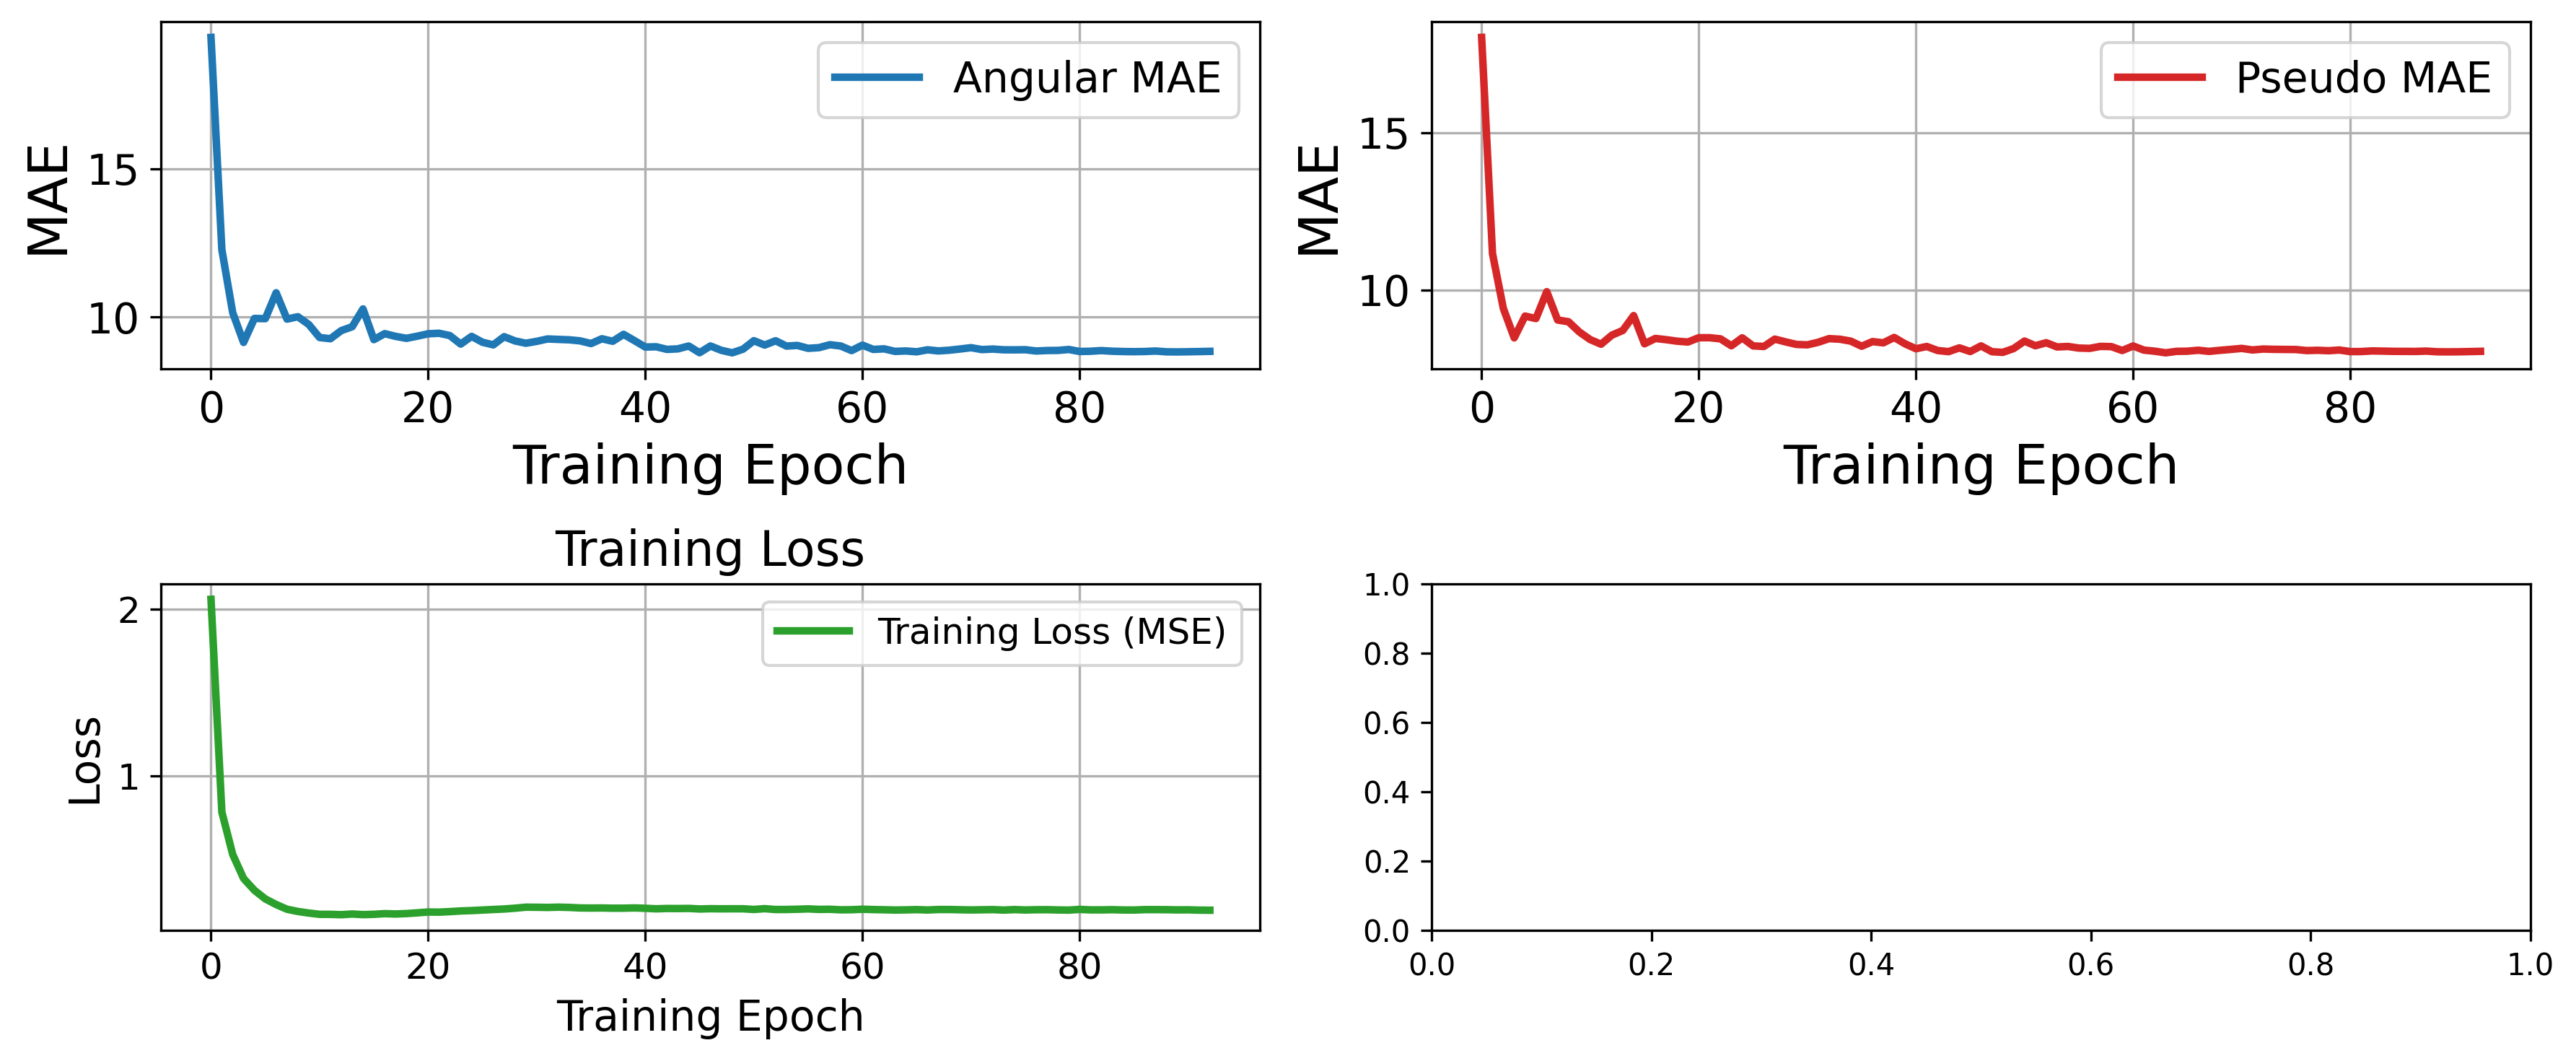

In [16]:
loss_list = [l.detach().cpu().item() if torch.is_tensor(l) else l for l in loss_list]
MAE_grid_list = [l.detach().cpu().item() if torch.is_tensor(l) else l for l in ang_mae_grid_list]
ang_mae_val_list = [l.detach().cpu().item() if torch.is_tensor(l) else l for l in ang_mae_val_list]

metrics_df = pd.DataFrame({
    'Epoch': list(range(len(loss_list))),
    'Training_Loss': loss_list,
#     'RMSE': RMSE_list,
    'MAE': MAE_grid_list,
    'ang-VAL-MAE':ang_mae_val_list,
#     'R2': R2_list
})


fig0, ax0 = plt.subplots(2, 2, figsize=(12, 5), dpi=300)

# ax0[0, 0].plot(RMSE_list, label='RMSE on test graph', linewidth=2.5)
ax0[0, 0].plot(MAE_grid_list, label='Angular MAE', linewidth=2.5)
ax0[0, 0].set_xlabel("Training Epoch", fontsize=18)
ax0[0, 0].set_ylabel("MAE", fontsize=18)
ax0[0, 0].tick_params(axis="both", labelsize=14)
ax0[0, 0].legend(fontsize=14)
ax0[0, 0].grid(True)

ax0[0, 1].plot(ang_mae_val_list, label='Pseudo MAE', linewidth=2.5, color='tab:red')
ax0[0, 1].set_xlabel("Training Epoch", fontsize=18)
ax0[0, 1].set_ylabel("MAE", fontsize=18)
ax0[0, 1].tick_params(axis="both", labelsize=14)
ax0[0, 1].legend(fontsize=14)
ax0[0, 1].grid(True)

# ax0[1, 0].plot(R2_list, label='R^2', linewidth=2.5, color='tab:red')
# ax0[1, 0].set_xlabel("Training Epoch", fontsize=18)
# ax0[1, 0].set_ylabel("Corr. Coeff.", fontsize=18)
# ax0[1, 0].tick_params(axis="both", labelsize=14)
# ax0[1, 0].legend(fontsize=14)
# ax0[1, 0].grid(True)

ax0[1, 0].plot(loss_list, label='Training Loss (MSE)', linewidth=2.5, color='tab:green')
ax0[1, 0].set_title("Training Loss", fontsize=16)
ax0[1, 0].set_xlabel("Training Epoch", fontsize=14)
ax0[1, 0].set_ylabel("Loss", fontsize=14)
ax0[1, 0].tick_params(axis="both", labelsize=12)
ax0[1, 0].legend(fontsize=12)
ax0[1, 0].grid(True)
fig0.tight_layout()

plot_dir = "/mnt/e/GNN_paper/iS-GNN/figures_maps/figs_out/"
plot_file = f"training_error_curves_{tags}.png"
plot_path = os.path.join(plot_dir, plot_file)
fig0.savefig(plot_path, bbox_inches='tight', dpi=300)



In [19]:
pg_idx.shape

(759,)

In [17]:
pred_cos = pred[0]
pred_sin = pred[1]
conf_mag = np.sqrt(pred_cos*pred_cos + pred_sin*pred_sin)
true_cos = X_target[:, 0]
true_sin = X_target[:, 1]

azi_pred = decode_azimuth(pred_cos, pred_sin)
azi_true = decode_azimuth(true_cos, true_sin)
azi_err  = np.minimum(np.abs(azi_pred - azi_true), 180 - np.abs(azi_pred - azi_true))
mae_deg  = azi_err.mean()

In [18]:
conf_mag = np.sqrt(pred_cos*pred_cos + pred_sin*pred_sin)
# mag_pred3.shape

df_test = node_info.copy()
conf_mc, _ = mc_dropout_uncertainty(STmodel, inp, A_q, A_h, T=20)
# ensure positional int indices 0.N-1 and within bounds
anchor_idx = np.asarray(anchor_idx, dtype=int)
conf_supp =  anchor_support(df_test['LON'].to_numpy(), df_test['LAT'].to_numpy(), anchor_idx, sigma_km=sigma_km)
conf_infl = multi_hop_anchor_influence(A, anchor_mask, K=2)

strength = 0.05*conf_mag + 0.2*conf_supp + 0.55*conf_infl + 0.2*conf_mc

In [20]:
# predictions on 15% validation set from the anchor nodes
pred_cos_val = pred[0, val_idx]
pred_sin_val = pred[1, val_idx]
true_cos_val = X_target[val_idx, 0]
true_sin_val = X_target[val_idx, 1]

azi_val_pred = decode_azimuth(pred_cos_val, pred_sin_val)
azi_val_true = decode_azimuth(true_cos_val, true_sin_val)

azi_val_err  = np.abs(azi_val_pred - azi_val_true)
azi_val_err  = np.minimum(azi_val_err, 180 - azi_val_err)

df_val['AZI_TRUE'] = azi_val_true
df_val['AZI_PRED'] = azi_val_pred
df_val['AZI_ERROR'] = azi_val_err

#Save as CSV
# val_result_dir = "/mnt/e/GNN_paper/2025_IGNNK/data/results_train/"
fname0 = f"iS_GNN_predictions_on_val_set_{tags}.csv"
val_csv_path = os.path.join(results_dir, fname0)
df_val.to_csv(val_csv_path, index=False)
print(f"CSV saved to: {val_csv_path}")

CSV saved to: /mnt/e/GNN_paper/iS-GNN/data/results_train/iS_GNN_predictions_on_val_set_ep_150_bs64_lr_5em04_k_diff_1_kNN_12_kernel_r_0_75_w_0_7em01.csv


In [21]:
df_val = node_info.iloc[val_idx].copy()
df_val['AZI_TRUE'] = azi_val_true
df_val['AZI_PRED'] = azi_val_pred
df_val['AZI_ERROR'] = azi_val_err

print(df_val[['ID', 'LON', 'LAT', 'AZI_TRUE', 'AZI_PRED', 'AZI_ERROR']].head())

# 5. Save as CSV
# csv_path1 = os.path.join(data_dir, f"iS_GNN_predictions_on_val_set_{file_prefix}.csv")
# df_val.to_csv(csv_path1, index=False)
# print(f"CSV saved to: {csv_path1}")

          ID     LON     LAT    AZI_TRUE    AZI_PRED  AZI_ERROR
22  wsm00286  26.185  39.027   92.000008   95.448761   3.448753
27  wsm00291  26.485  39.120   84.000000   97.773460  13.773460
28  wsm00292  26.563  39.108   74.000000   97.541901  23.541901
30  wsm00294  24.583  40.625   84.000000  104.430626  20.430626
40  wsm00404   5.852  50.893  132.000000  129.795578   2.204422


In [38]:
# # predictions on 15% validation set from the anchor nodes
# pred_cos_pg = pred[0, pg_idx]
# pred_sin_pg = pred[1, pg_idx]
# true_cos_pg = X_target[pg_idx, 0]
# true_sin_pg = X_target[pg_idx, 1]

# azi_pg_pred = decode_azimuth(pred_cos_pg, pred_sin_pg)
# azi_pg_true = decode_azimuth(true_cos_pg, true_sin_pg)

# azi_pg_err  = np.abs(azi_pg_pred - azi_pg_true)
# azi_pg_err  = np.minimum(azi_pg_err, 180 - azi_pg_err)

# df_pg = node_info.iloc[pg_idx].copy()

# df_pg['AZI_TRUE'] = azi_pg_true
# df_pg['AZI_PRED'] = azi_pg_pred
# df_pg['AZI_ERROR'] = azi_pg_err

# #Save as CSV
# pg_result_dir = "/mnt/e/GNN_paper/2025_IGNNK/data/results_train/"
# fname0 = f"iS_GNN_predictions_on_PSEUDO_GRID_set_{tags}.csv"
# pg_csv_path = os.path.join(pg_result_dir, fname0)
# df_pg.to_csv(pg_csv_path, index=False)
# print(f"CSV saved to: {pg_csv_path}")

CSV saved to: /mnt/e/GNN_paper/2025_IGNNK/data/results_train/iS_GNN_predictions_on_PSEUDO_GRID_set_ep_150_bs64_lr5em04_z96_k_diff_1_kNN_8_ramps_30_b_cap_90.csv


In [27]:
# df_val = node_info.iloc[val_idx].copy()

In [20]:
df_val.head()

,ID,LON,LAT,DEPTH,DIST,PLATE,QUALITY,REGIME,AZI,geometry,AZI_TRUE,AZI_PRED,AZI_ERROR
22,wsm00286,26.185,39.027,0.0,47.0,AS,C,NS,92.0,POINT (26.18500 39.02700),92.000008,95.296684,3.296677
27,wsm00291,26.485,39.120,0.0,23.0,AS,B,NF,84.0,POINT (26.48500 39.12000),84.000000,91.903351,7.903351
28,wsm00292,26.563,39.108,0.0,22.0,AS,C,NF,74.0,POINT (26.56300 39.10800),74.000000,90.695702,16.695702
30,wsm00294,24.583,40.625,0.0,63.0,EU,B,NF,84.0,POINT (24.58300 40.62500),84.000000,97.377670,13.377670
40,wsm00404,5.852,50.893,20.5,1378.0,EU,C,NF,132.0,POINT (5.85200 50.89300),132.000000,131.067078,0.932922


In [22]:

df_test['AZI'] = azi_true
df_test['AZI_PRED'] = azi_pred
df_test['AZI_ERROR'] = azi_err
# df_test3['MAG']=mag_pred3
df_test['STR']=strength
df_test = df_test[['ID', 'LON','LAT','geometry','PLATE', 'REGIME' ,'DIST', 'QUALITY' ,'AZI' ,'AZI_PRED','AZI_ERROR', 'STR']]


In [23]:
fname0 = f"iS-GNN_grid_1p0r_results_{tags}.csv"
fname1 = f"iS-GNN_anchor_1p0r_results_{tags}.csv"
csv_path0 = os.path.join(results_dir, fname0)
csv_path1 = os.path.join(results_dir, fname1)
df_test[df_test["ID"].str.startswith("grid_")].to_csv(csv_path0, index=False)
df_test[df_test["ID"].str.startswith("wsm")].to_csv(csv_path1, index=False)

In [24]:
#Here change GRID-I.csv to the desired grid one needs to perform interplations.
#GRID-A.csv, GRID-B.csv, ..., GRID-H.csv are the nested grids.
grid_gdf3 = "/mnt/e/GNN_paper/iS-GNN/data/grids_interp/GRID-A.csv"
sh_dat_3 = generate_shmax_train_data(anchor_data_path, grid_gdf3)
sh_dat_3 = generate_shmax_train_data(
                              anchor_data_path,
                              grid_gdf3,
                              kNN = kNN,
#                               sigma_km = sigma_km,
                              qual_R_km = sigma_km,
                              Q_cut_frac = quality_frac,
                              Q_mode=q_mode,
                              theta_bound_deg = th_bound,
                              kernel_w_0 = w_0, #to aid sigma_km auto selection
                              kernel_percentile_r_0 = r_0 #to aid sigma_km auto selection
)

A3, X_target3, grid_gdf3, anchor_gdf3,node_info3 = load_shmax_train_data()

grid_gdf3 = grid_gdf3[df_cols]
node_info3 = node_info3[df_cols]
anchor_gdf3 = anchor_gdf3[df_cols]

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$44

# max_depth3 = node_info3['DEPTH'].max()
max_dist3  = node_info3['DIST'].max()

# depth_feat3 = node_info3['DEPTH'].fillna(0) / max_depth3
dist_feat3  = node_info3['DIST'].fillna(0) / max_dist3

# Load encoder
with open("data/num_array_files/ppb_encoder.pkl", "rb") as f:
    encoder = pickle.load(f)
# Use it to transform the new region
cat_features3 = encoder.transform(node_info3[["PLATE", 'QUALITY' ,"REGIME"]])

X_aux3 = np.column_stack([dist_feat3, cat_features3])  # shape (N , p)

X_total3 = np.concatenate([X_target3, X_aux3], axis=-1)   # (N , h_total)

######################################
rng = np.random.default_rng(42)          # reproducible split

anchor_mask3 = (np.abs(X_total3[:, 0]) + np.abs(X_total3[:, 1])) > 1e-4
grid_mask3 = ~anchor_mask3
anchor_idx3 = np.where(anchor_mask3)[0]
grid_idx3 = np.where(grid_mask3)[0]
know_set3 = set(anchor_idx3)
unknow_set3 = set(grid_idx3)
##
train_anchor_idx3 = set(know_set3)            # NO val anchors inside
proto_xy3, proto_cs3 = build_anchor_prototypes(
    node_info=node_info3,
    X_total=X_total3,                         # shape (N, h_total) with first 2 = targets
    train_anchor_idx=train_anchor_idx3,
    K=6,                                     # try 3–6
    w_space=1
)

P3 = prototype_prior(                         # (2, N)
    node_info=node_info3,
    proto_xy=proto_xy3, proto_cs=proto_cs3,
    sigma_km=sigma_km,                           # spatial influence; try 80–120 km
    topK=3                                   # blend at most the 2 nearest prototypes
)

X_total3 = np.concatenate([X_total3, P3.T], axis=1)        # now (N, 2 + p + 2)

# Keep track of sizes
h_target3 = 2
h_total3  = X_total3.shape[1]          # this increased by 2
h_aux3    = h_total3 - h_target3
#######################################

print(f" Prepared input: {X_total3.shape[0]} nodes x {X_total3.shape[1]} features")


inp_3 = torch.from_numpy(X_total3.T.astype('float32')[np.newaxis])
A_q_3 = torch.from_numpy(calculate_random_walk_matrix(A3).T.astype('float32'))
A_h_3 = torch.from_numpy(calculate_random_walk_matrix(A3.T).T.astype('float32'))

with torch.no_grad():
    out3 = STmodel(inp_3, A_q_3, A_h_3)[0].cpu().numpy()   # shape (2 , N_test)

pred_cos3 = out3[0]
pred_sin3 = out3[1]
mag_pred3 = np.sqrt(pred_cos3*pred_cos3 + pred_sin3*pred_sin3)
true_cos3 = X_target3[:, 0]
true_sin3 = X_target3[:, 1]

azi_pred3 = decode_azimuth(pred_cos3, pred_sin3)
azi_true3 = decode_azimuth(true_cos3, true_sin3)
azi_err3  = np.minimum(np.abs(azi_pred3 - azi_true3), 180 - np.abs(azi_pred3 - azi_true3))
mae_deg3  = azi_err3.mean()

print(f"Angular MAE at 0.6 degree resolution: {mae_deg3:.2f} degrees")

conf_mag = np.sqrt(pred_cos3*pred_cos3 + pred_sin3*pred_sin3)
# mag_pred3.shape

df_test3 = node_info3.copy()
conf_mc, _ = mc_dropout_uncertainty(STmodel, inp_3, A_q_3, A_h_3, T=20)
# ensure positional int indices 0..N-1 and within bounds
anchor_idx3 = np.asarray(anchor_idx3, dtype=int)
conf_supp =  anchor_support(df_test3['LON'].to_numpy(), df_test3['LAT'].to_numpy(), anchor_idx3, sigma_km=sigma_km)
conf_infl = multi_hop_anchor_influence(A3, anchor_mask3, K=2)

strength = 0.05*conf_mag + 0.2*conf_supp + 0.55*conf_infl + 0.2*conf_mc


df_test3['AZI'] = azi_true3
df_test3['AZI_PRED'] = azi_pred3
df_test3['AZI_ERROR'] = azi_err3
# df_test3['MAG']=mag_pred3
df_test3['STR']=strength
df_test3 = df_test3[['ID', 'LON','LAT','geometry','PLATE', 'REGIME' ,'DIST', 'QUALITY' ,'AZI' ,'AZI_PRED','AZI_ERROR', 'STR']]

fname0 = f"iS-GNN_grid_0p6Ir_results_{tags}.csv"
fname1 = f"iS-GNN_anchor_0p6Ir_results_{tags}.csv"
csv_path0 = os.path.join(results_dir, fname0)
csv_path1 = os.path.join(results_dir, fname1)
df_test3[df_test3["ID"].str.startswith("grid_")].to_csv(csv_path0, index=False)
df_test3[df_test3["ID"].str.startswith("wsm")].to_csv(csv_path1, index=False)


 Prepared input: 4555 nodes x 18 features
Angular MAE at 0.6 degree resolution: 8.91 degrees


In [25]:
grid_gdf4 = "data/grids_train/all_grid_data_0p2r.csv"
# sh_dat_4 = generate_shmax_train_data(anchor_data_path, grid_gdf4)
sh_dat_4 = generate_shmax_train_data(
                              anchor_data_path,
                              grid_gdf4,
                              kNN = kNN,
#                               sigma_km = sigma_km,
                              qual_R_km = sigma_km,
                              Q_cut_frac = quality_frac,
                              Q_mode=q_mode,
                              theta_bound_deg = th_bound,
                              kernel_w_0 = w_0, #to aid sigma_km auto selection
                              kernel_percentile_r_0 = r_0 #to aid sigma_km auto selection
)

A4, X_target4, grid_gdf4, anchor_gdf4,node_info4 = load_shmax_train_data()

grid_gdf4 = grid_gdf4[df_cols]
node_info4 = node_info4[df_cols]
anchor_gdf4 = anchor_gdf4[df_cols]

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$44

# max_depth3 = node_info3['DEPTH'].max()
max_dist4  = node_info4['DIST'].max()

# depth_feat3 = node_info3['DEPTH'].fillna(0) / max_depth3
dist_feat4  = node_info4['DIST'].fillna(0) / max_dist4

# Load encoder
with open("data/num_array_files/ppb_encoder.pkl", "rb") as f:
    encoder = pickle.load(f)
# Use it to transform the new region
cat_features4 = encoder.transform(node_info4[["PLATE", 'QUALITY' ,"REGIME"]])

X_aux4 = np.column_stack([dist_feat4, cat_features4])  # shape (N , p)

X_total4 = np.concatenate([X_target4, X_aux4], axis=-1)   # (N , h_total)

######################################
rng = np.random.default_rng(42)          # reproducible split

anchor_mask4 = (np.abs(X_total4[:, 0]) + np.abs(X_total4[:, 1])) > 1e-4
grid_mask4 = ~anchor_mask4
anchor_idx4 = np.where(anchor_mask4)[0]
grid_idx4 = np.where(grid_mask4)[0]
know_set4 = set(anchor_idx4)
unknow_set4 = set(grid_idx4)
##
train_anchor_idx4 = set(know_set4)            # NO val anchors inside
proto_xy4, proto_cs4 = build_anchor_prototypes(
    node_info=node_info4,
    X_total=X_total4,                         # shape (N, h_total) with first 2 = targets
    train_anchor_idx=train_anchor_idx4,
    K=3,                                     # try 3–6
    w_space=1
)

P4 = prototype_prior(                         # (2, N)
    node_info=node_info4,
    proto_xy=proto_xy4, proto_cs=proto_cs4,
    sigma_km=sigma_km,                           # spatial influence; try 80–120 km
    topK=3                                   # blend at most the 2 nearest prototypes
)

X_total4 = np.concatenate([X_total4, P4.T], axis=1)        # now (N, 2 + p + 2)

# Keep track of sizes
h_target4 = 2
h_total4  = X_total4.shape[1]          # this increased by 2
h_aux4    = h_total4 - h_target4
#######################################

print(f" Prepared input: {X_total4.shape[0]} nodes x {X_total4.shape[1]} features")


inp_4 = torch.from_numpy(X_total4.T.astype('float32')[np.newaxis])
A_q_4 = torch.from_numpy(calculate_random_walk_matrix(A4).T.astype('float32'))
A_h_4 = torch.from_numpy(calculate_random_walk_matrix(A4.T).T.astype('float32'))

with torch.no_grad():
    out4 = STmodel(inp_4, A_q_4, A_h_4)[0].cpu().numpy()   # shape (2 , N_test)

pred_cos4 = out4[0]
pred_sin4 = out4[1]
true_cos4 = X_target4[:, 0]
true_sin4 = X_target4[:, 1]

azi_pred4 = decode_azimuth(pred_cos4, pred_sin4)
azi_true4 = decode_azimuth(true_cos4, true_sin4)
azi_err4  = np.minimum(np.abs(azi_pred4 - azi_true4), 180 - np.abs(azi_pred4 - azi_true4))
mae_deg4  = azi_err4.mean()

print(f"Angular MAE at 0.2 degree resolution: {mae_deg4:.2f}")


 Prepared input: 5208 nodes x 18 features
Angular MAE at 0.2 degree resolution: 12.35


In [36]:
conf_mag4 = np.sqrt(pred_cos4*pred_cos4 + pred_sin4*pred_sin4)
# mag_pred3.shape

df_test4 = node_info4.copy()
conf_mc4, _ = mc_dropout_uncertainty(STmodel, inp_4, A_q_4, A_h_4, T=20)
# ensure positional int indices 0..N-1 and within bounds
anchor_idx4 = np.asarray(anchor_idx4, dtype=int)
conf_supp4 =  anchor_support(df_test4['LON'].to_numpy(), df_test4['LAT'].to_numpy(), anchor_idx4, sigma_km=sigma_km)
conf_infl4 = multi_hop_anchor_influence(A4, anchor_mask4, K=2)

strength4 = 0.05*conf_mag4 + 0.2*conf_supp4 + 0.55*conf_infl4 + 0.2*conf_mc4

In [150]:
# df_test6[df_test6['AZI']==0].to_csv('/mnt/e/GNN_paper/IGNNK/data/wsm2016/gmt_plots/POSTER-AI-DAY/NEW_GRID_GNN_INTERPOLATIONS.csv', index=False)

In [37]:
df_test4 = node_info4.copy()
df_test4['AZI'] = azi_true4
df_test4['AZI_PRED'] = azi_pred4
df_test4['AZI_ERROR'] = azi_err4
df_test4['STR'] = strength4
df_test4 = df_test4[['ID', 'LON','LAT','geometry','PLATE', 'REGIME' ,'DIST', 'QUALITY' ,'AZI' ,'AZI_PRED','AZI_ERROR', 'STR']]

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# results_dir = "/mnt/e/GNN_paper/2025_IGNNK/data/results_train/"
fname0 = f"iS-GNN_grid_0p2r_results_{tags}.csv"
fname1 = f"iS-GNN_anchor_0p2r_results_{tags}.csv"
csv_path0 = os.path.join(results_dir, fname0)
csv_path1 = os.path.join(results_dir, fname1)
df_test4[df_test4["ID"].str.startswith("grid_")].to_csv(csv_path0, index=False)
df_test4[df_test4["ID"].str.startswith("wsm")].to_csv(csv_path1, index=False)

In [49]:
grid_gdf5 = "data/grids_train/all_grid_data_1p5r.csv"
# sh_dat_4 = generate_shmax_train_data(anchor_data_path, grid_gdf4)
sh_dat_5 = generate_shmax_train_data(
                              anchor_data_path,
                              grid_gdf5,
                              kNN = kNN,
#                               sigma_km = sigma_km,
                              qual_R_km = sigma_km,
                              Q_cut_frac = quality_frac,
                              Q_mode=q_mode,
                              theta_bound_deg = th_bound,
                              kernel_w_0 = w_0, #to aid sigma_km auto selection
                              kernel_percentile_r_0 = r_0 #to aid sigma_km auto selection    
)

A5, X_target5, grid_gdf5, anchor_gdf5,node_info5 = load_shmax_train_data()

grid_gdf5 = grid_gdf5[df_cols]
node_info5 = node_info5[df_cols]
anchor_gdf5 = anchor_gdf5[df_cols]

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$44

# max_depth3 = node_info3['DEPTH'].max()
max_dist5  = node_info5['DIST'].max()

# depth_feat3 = node_info3['DEPTH'].fillna(0) / max_depth3
dist_feat5  = node_info5['DIST'].fillna(0) / max_dist5

# Load encoder
with open("data/num_array_files/ppb_encoder.pkl", "rb") as f:
    encoder = pickle.load(f)
# Use it to transform the new region
cat_features5 = encoder.transform(node_info5[["PLATE", 'QUALITY' ,"REGIME"]])

X_aux5 = np.column_stack([dist_feat5, cat_features5])  # shape (N , p)

X_total5 = np.concatenate([X_target5, X_aux5], axis=-1)   # (N , h_total)

######################################
rng = np.random.default_rng(42)          # reproducible split

anchor_mask5 = (np.abs(X_total5[:, 0]) + np.abs(X_total5[:, 1])) > 1e-4
grid_mask5 = ~anchor_mask5
anchor_idx5 = np.where(anchor_mask5)[0]
grid_idx5 = np.where(grid_mask5)[0]
know_set5 = set(anchor_idx5)
unknow_set5 = set(grid_idx5)
##
train_anchor_idx5 = set(know_set5)            # NO val anchors inside
proto_xy5, proto_cs5 = build_anchor_prototypes(
    node_info=node_info5,
    X_total=X_total5,                         # shape (N, h_total) with first 2 = targets
    train_anchor_idx=train_anchor_idx5,
    K=3,                                     # try 3–6
    w_space=1
)

P5 = prototype_prior(                         # (2, N)
    node_info=node_info5,
    proto_xy=proto_xy5, proto_cs=proto_cs5,
    sigma_km=sigma_km,                           # spatial influence; try 80–120 km
    topK=3                                   # blend at most the 2 nearest prototypes
)

X_total5 = np.concatenate([X_total5, P5.T], axis=1)        # now (N, 2 + p + 2)

# Keep track of sizes
h_target5 = 2
h_total5  = X_total5.shape[1]          # this increased by 2
h_aux5    = h_total5 - h_target5
#######################################

print(f" Prepared input: {X_total5.shape[0]} nodes x {X_total5.shape[1]} features")


inp_5 = torch.from_numpy(X_total5.T.astype('float32')[np.newaxis])
A_q_5 = torch.from_numpy(calculate_random_walk_matrix(A5).T.astype('float32'))
A_h_5 = torch.from_numpy(calculate_random_walk_matrix(A5.T).T.astype('float32'))

with torch.no_grad():
    out5 = STmodel(inp_5, A_q_5, A_h_5)[0].cpu().numpy()   # shape (2 , N_test)

pred_cos5 = out5[0]
pred_sin5 = out5[1]
true_cos5 = X_target5[:, 0]
true_sin5 = X_target5[:, 1]

azi_pred5 = decode_azimuth(pred_cos5, pred_sin5)
azi_true5 = decode_azimuth(true_cos5, true_sin5)
azi_err5  = np.minimum(np.abs(azi_pred5 - azi_true5), 180 - np.abs(azi_pred5 - azi_true5))
mae_deg5  = azi_err5.mean()

print(f"Angular MAE at 1.5 degree resolution: {mae_deg5:.2f}")


 Prepared input: 4762 nodes x 18 features
Angular MAE at 1.5 degree resolution: 10.35


In [46]:
conf_mag5 = np.sqrt(pred_cos5*pred_cos5 + pred_sin5*pred_sin5)
# mag_pred3.shape

df_test5 = node_info5.copy()
conf_mc5, _ = mc_dropout_uncertainty(STmodel, inp_5, A_q_5, A_h_5, T=20)
# ensure positional int indices 0..N-1 and within bounds
anchor_idx5 = np.asarray(anchor_idx5, dtype=int)
conf_supp5 =  anchor_support(df_test5['LON'].to_numpy(), df_test5['LAT'].to_numpy(), anchor_idx5, sigma_km=sigma_km)
conf_infl5 = multi_hop_anchor_influence(A5, anchor_mask5, K=2)

strength5 = 0.05*conf_mag5 + 0.2*conf_supp5 + 0.55*conf_infl5 + 0.2*conf_mc5

In [47]:
# df_test4 = node_info4.copy()
df_test5['AZI'] = azi_true5
df_test5['AZI_PRED'] = azi_pred5
df_test5['AZI_ERROR'] = azi_err5
df_test5['STR'] = strength5
df_test5 = df_test5[['ID', 'LON','LAT','geometry','PLATE', 'REGIME' ,'DIST', 'QUALITY' ,'AZI' ,'AZI_PRED','AZI_ERROR', 'STR']]

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# results_dir = "/mnt/e/GNN_paper/2025_IGNNK/data/results_train/"
fname0 = f"iS-GNN_grid_0p5r_results_{tags}.csv"
fname1 = f"iS-GNN_anchor_0p5r_results_{tags}.csv"
csv_path0 = os.path.join(results_dir, fname0)
csv_path1 = os.path.join(results_dir, fname1)
df_test5[df_test5["ID"].str.startswith("grid_")].to_csv(csv_path0, index=False)
df_test5[df_test5["ID"].str.startswith("wsm")].to_csv(csv_path1, index=False)

In [50]:
# Retry the merge: load all files, tag with source, concatenate, and save
import pandas as pd
from pathlib import Path

files = [
    "data/results_train/iS-GNN_grid_0p6Ar_results_ep_150_bs64_lr_5em04_k_diff_1_kNN_12_kernel_r_0_75_w_0_7em01.csv",
    "data/results_train/iS-GNN_grid_0p6Br_results_ep_150_bs64_lr_5em04_k_diff_1_kNN_12_kernel_r_0_75_w_0_7em01.csv",
    "data/results_train/iS-GNN_grid_0p6Cr_results_ep_150_bs64_lr_5em04_k_diff_1_kNN_12_kernel_r_0_75_w_0_7em01.csv",
    "results_train/iS-GNN_grid_0p6Dr_results_ep_150_bs64_lr_5em04_k_diff_1_kNN_12_kernel_r_0_75_w_0_7em01.csv",
    "data/results_train/iS-GNN_grid_0p6Er_results_ep_150_bs64_lr_5em04_k_diff_1_kNN_12_kernel_r_0_75_w_0_7em01.csv",
    "data/results_train/iS-GNN_grid_0p6Fr_results_ep_150_bs64_lr_5em04_k_diff_1_kNN_12_kernel_r_0_75_w_0_7em01.csv",
    "data/results_train/iS-GNN_grid_0p6Gr_results_ep_150_bs64_lr_5em04_k_diff_1_kNN_12_kernel_r_0_75_w_0_7em01.csv",
    "data/results_train/iS-GNN_grid_0p6Hr_results_ep_150_bs64_lr_5em04_k_diff_1_kNN_12_kernel_r_0_75_w_0_7em01.csv",
    "data/results_train/iS-GNN_grid_0p6Ir_results_ep_150_bs64_lr_5em04_k_diff_1_kNN_12_kernel_r_0_75_w_0_7em01.csv",
]

dfs = []
for p in files:
    df = pd.read_csv(p)
    df["SOURCE_FILE"] = Path(p).name
    dfs.append(df)

merged = pd.concat(dfs, ignore_index=True)

sort_cols = [c for c in ["LON", "LAT"] if c in merged.columns]
if sort_cols:
    merged = merged.sort_values(sort_cols).reset_index(drop=True)

out_path = "/mnt/e/GNN_paper/2025_IGNNK/data/results_train/iS-GNN_grid_0p2r_nested_graph.csv"
merged.to_csv(out_path, index=False)

(len(merged), merged.columns.tolist()[:10], out_path)


(742,
 ['ID',
  'LON',
  'LAT',
  'geometry',
  'PLATE',
  'REGIME',
  'DIST',
  'QUALITY',
  'AZI',
  'AZI_PRED'],
 '/mnt/e/GNN_paper/2025_IGNNK/data/results_train/iS-GNN_grid_0p2r_nested_graph.csv')